## Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt
import sklearn
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Flatten, Dropout
from keras.layers.core import Dense, Activation
import tensorflow as tf

import xgboost as xgb
from xgboost import plot_importance, plot_tree

from sklearn.metrics import mean_squared_error, mean_absolute_error

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import joblib

from sklearn.metrics import r2_score
from scipy import stats

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Model definition

### AMB model

#### Data Processing & Cleaning

In [6]:
def generar_train_test_datasets():
    dataURLRegiones='https://raw.githubusercontent.com/DavidGD03/plastics-COVID_project/main/data/India_5_Regiones_Simultech3/'
    bmw_dataS=pd.read_excel('https://raw.githubusercontent.com/DavidGD03/plastics-COVID_project/main/data/india/total_bmw_waste.xlsx?raw=true',sheet_name=2)
    bmw_dataS['FECHA'] = pd.to_datetime(bmw_dataS['FECHA'], infer_datetime_format=True)
    bmw_dataS=bmw_dataS.fillna(bmw_dataS.mean())
    bmw_dataS=bmw_dataS.set_index('FECHA')
    df_multivariable=pd.read_csv(dataURLRegiones+'df_multivariable_AMB.csv')

    df_multivariable['FECHA'] = pd.to_datetime(df_multivariable['FECHA'], infer_datetime_format=True)
    df_multivariable=df_multivariable.set_index('FECHA')
    df_real_data = df_multivariable.copy(deep=True)

    train_MRNN_sc=df_multivariable['2020-06-17':'2021-08-30']
    test_MRNN_sc=df_multivariable['2021-09-01':]
    return train_MRNN_sc, test_MRNN_sc, df_real_data

In [7]:
df_train, df_test,df_real_data=generar_train_test_datasets()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """


In [8]:
df_real_data_lr = df_real_data.copy()
df_real_data_lr.columns = ['BMW', 'Cases', 'Deaths', 'Residential_Mob', 'Workplaces_Mob', 'Transit_Mob']

In [9]:
df_real_data_lr

,BMW,Cases,Deaths,Residential_Mob,Workplaces_Mob,Transit_Mob
FECHA,,,,,,
2020-06-17,1.737210,6.857143,1.0,18.000000,-33.333333,-35.666667
2020-06-18,1.737210,8.000000,0.0,18.333333,-34.000000,-41.000000
2020-06-19,1.737210,9.142857,1.0,16.333333,-28.333333,-35.666667
2020-06-20,1.737210,10.714286,0.0,15.000000,-18.666667,-37.333333
2020-06-21,1.737210,11.857143,0.0,20.000000,-32.000000,-61.333333
...,...,...,...,...,...,...
2021-12-27,0.400507,87.285714,1.0,4.000000,3.333333,71.333333
2021-12-28,0.400507,112.714286,1.0,2.333333,7.333333,81.000000
2021-12-29,0.400507,139.000000,2.0,1.333333,4.000000,91.666667


#### Lineal Regressor

In [10]:
import statsmodels.formula.api as sm

In [11]:
formula1 = 'BMW ~ Cases + Deaths + Residential_Mob + Workplaces_Mob + Transit_Mob'
formula1

'BMW ~ Cases + Deaths + Residential_Mob + Workplaces_Mob + Transit_Mob'

In [12]:
model1 = sm.ols(formula = formula1, data = df_real_data_lr)

In [13]:
fitted1 = model1.fit()

In [14]:
print(fitted1.summary())

                            OLS Regression Results                            
Dep. Variable:                    BMW   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     404.5
Date:                Fri, 12 Aug 2022   Prob (F-statistic):          1.02e-182
Time:                        22:33:35   Log-Likelihood:                -390.27
No. Observations:                 563   AIC:                             792.5
Df Residuals:                     557   BIC:                             818.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.8921      0.073     

In [ ]:
fitted1.params

Intercept          1.892102
Casos              0.001855
Muertes            0.018443
Mov_Residencial   -0.022520
Mov_trabajo        0.001653
Mov_estaciones    -0.013199
dtype: float64

#### XGBoost Regressor

In [16]:
df_train

,BMW,Casos,Muertes,Mov Residencial,Mov trabajo,Mov estaciones
FECHA,,,,,,
2020-06-17,1.737210,6.857143,1.0,18.000000,-33.333333,-35.666667
2020-06-18,1.737210,8.000000,0.0,18.333333,-34.000000,-41.000000
2020-06-19,1.737210,9.142857,1.0,16.333333,-28.333333,-35.666667
2020-06-20,1.737210,10.714286,0.0,15.000000,-18.666667,-37.333333
2020-06-21,1.737210,11.857143,0.0,20.000000,-32.000000,-61.333333
...,...,...,...,...,...,...
2021-08-26,1.249747,34.000000,1.0,7.000000,3.666667,30.000000
2021-08-27,1.249747,33.571429,0.0,5.333333,13.333333,32.333333
2021-08-28,1.249747,35.000000,0.0,2.666667,20.333333,35.333333


In [17]:
df_train.columns = ['BMW', 'Cases', 'Deaths', 'Residential_Mob', 'Workplaces_Mob', 'Transit_Mob']
df_test.columns = ['BMW', 'Cases', 'Deaths', 'Residential_Mob', 'Workplaces_Mob', 'Transit_Mob']

In [18]:
def create_features(df, label=None):
    
    X = df[['Cases', 'Deaths', 'Residential_Mob', 'Workplaces_Mob', 'Transit_Mob']]
    if label:
        y = df[label]
        return X, y
    return X

In [19]:
# Creamos los datasets de train y test. 
# Las variables predictoras serán distintos parámetros de la fecha, y la variable Is_Holiday
# La variable a predecir es el consumo de energía BMW
X_train, y_train = create_features(df_train, label='BMW')
X_test, y_test = create_features(df_test, label='BMW')

In [20]:
# Entrenamos el modelo XGB Regressor
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

[22:35:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=1000)

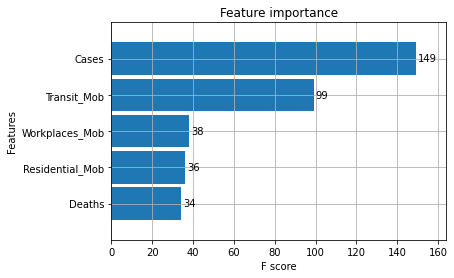

In [21]:
# Ver la importancia de cada feature en la predicción
plot_importance(reg, height=0.9)

In [ ]:
# Realizamos la predicción de los datos de test
df_test['BMW_Prediction'] = reg.predict(X_test)
df_all = pd.concat([df_test, df_train], sort=False)

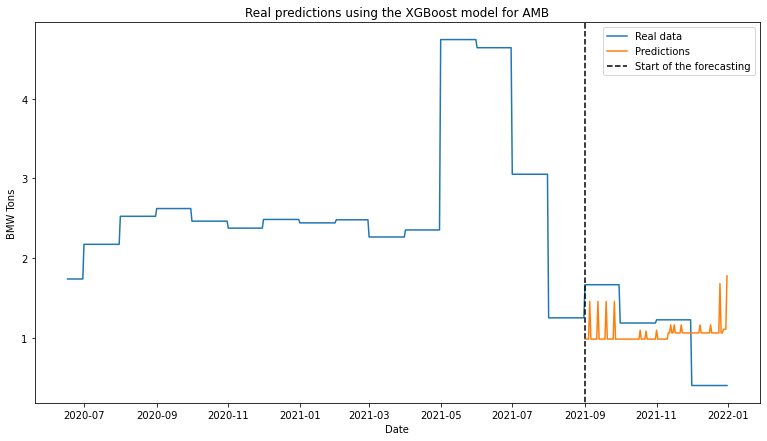

In [ ]:
fig = plt.figure(figsize=(13, 7))
plt.plot(df_real_data.index,df_real_data['BMW'], label="Real data")
plt.plot(df_all.index,df_all['BMW_Prediction'],label="Predictions")
plt.axvline(x=datetime.date(2021, 9, 1), ymin=-1, ymax=2,color="black",linestyle = "dashed",label="Start of the forecasting")
plt.legend(loc='best')
plt.title("Real predictions using the XGBoost model for AMB")
plt.xlabel("Date")
plt.ylabel("BMW Tons")
plt.show()

In [ ]:
def generar_train_test_datasets_SEIR(escenario):
    dataURLRegiones='https://raw.githubusercontent.com/DavidGD03/plastics-COVID_project/main/data/India_5_Regiones_Simultech3/'
    dataURLSEIRD='https://raw.githubusercontent.com/DavidGD03/plastics-COVID_project/main/data/SEIRD_AMB_Paper/'
    df_multivariable=pd.read_csv(dataURLRegiones+'df_multivariable_AMB.csv')
    #df_multivariable['FECHA'] = pd.to_datetime(df_multivariable['FECHA'], infer_datetime_format=True)
    df_multivariable=df_multivariable.set_index('FECHA')
    if escenario == 'pessimistic':
        df_I=pd.read_csv(dataURLSEIRD+'ISEIRDPESIMISTA.csv',names=['FECHA','AMB'],header=0, index_col='FECHA')
        df_D=pd.read_csv(dataURLSEIRD+'DSEIRDPESIMISTA.csv',names=['FECHA','AMB'],header=0, index_col='FECHA')
        df_multivariable['Casos']=df_I['AMB']
        df_multivariable['Muertes']=df_D['AMB']
    elif escenario == 'neutral':
        df_I=pd.read_csv(dataURLSEIRD+'ISEIRDNEUTRAL.csv',names=['FECHA','AMB'],header=0, index_col='FECHA')
        df_D=pd.read_csv(dataURLSEIRD+'DSEIRDNEUTRAL.csv',names=['FECHA','AMB'],header=0, index_col='FECHA')
        df_multivariable['Casos']=df_I['AMB']
        df_multivariable['Muertes']=df_D['AMB']
    elif escenario == 'optimistic':
        df_I=pd.read_csv(dataURLSEIRD+'ISEIRDOPTIMISTA.csv',names=['FECHA','AMB'],header=0, index_col='FECHA')
        df_D=pd.read_csv(dataURLSEIRD+'DSEIRDOPTIMISTA.csv',names=['FECHA','AMB'],header=0, index_col='FECHA')
        df_multivariable['Casos']=df_I
        df_multivariable['Muertes']=df_D
    df_multivariable.index = pd.to_datetime(df_multivariable.index, infer_datetime_format=True)
    test_MRNN_sc=df_multivariable['2021-09-01':]
    
    return test_MRNN_sc, df_I

In [ ]:
lista_escenarios = ['pessimistic', 'neutral', 'optimistic']
for escenario in lista_escenarios:
  current_df_test, df_I = generar_train_test_datasets_SEIR(escenario)
  X_test, y_test = create_features(current_df_test, label='BMW')
  df_test['BMW_Prediction_' + escenario] = reg.predict(X_test)

In [ ]:
dataURLRegiones='https://raw.githubusercontent.com/DavidGD03/plastics-COVID_project/main/data/India_5_Regiones_Simultech3/'
df_real_data=pd.read_csv(dataURLRegiones+'df_multivariable_AMB.csv')
df_real_data['FECHA'] = pd.to_datetime(df_real_data['FECHA'], infer_datetime_format=True)
df_real_data=df_real_data.set_index('FECHA')

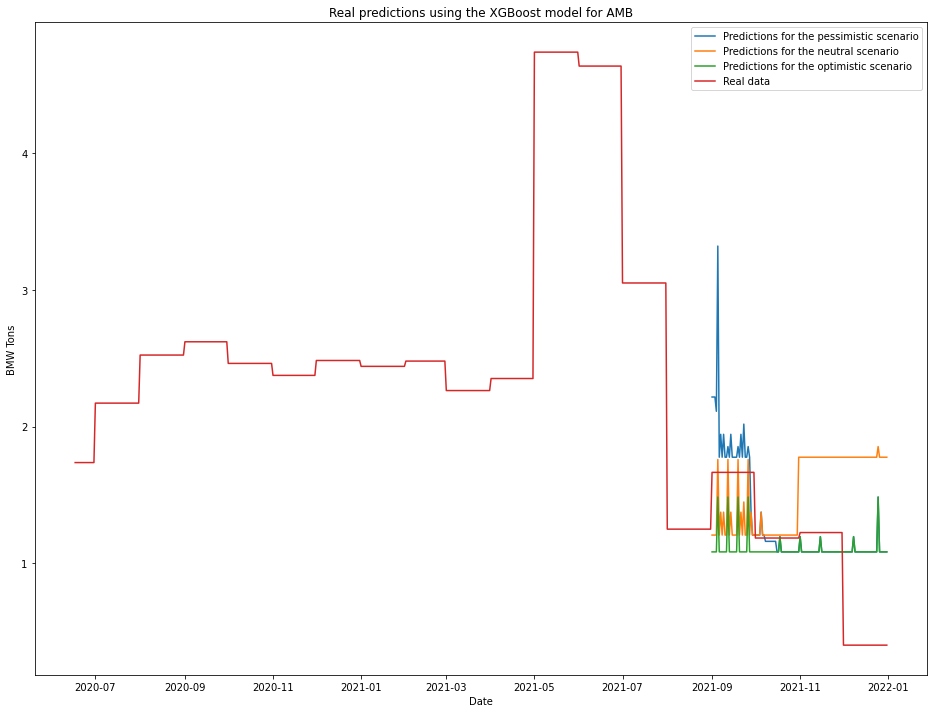

In [ ]:
fig = plt.figure(figsize=(16, 12))
for escenario in lista_escenarios:
  plt.plot(df_test.index,df_test['BMW_Prediction_' + escenario],label="Predictions for the " + escenario + " scenario")
#df_test[['BMW_Prediction_pessimistic','BMW_Prediction_neutral','BMW_Prediction_optimistic']].plot(figsize=(15, 5))
plt.plot(df_real_data.index,df_real_data['BMW'], label="Real data")
plt.legend(loc='best')
plt.title("Real predictions using the XGBoost model for AMB")
plt.xlabel("Date")
plt.ylabel("BMW Tons")
plt.show()

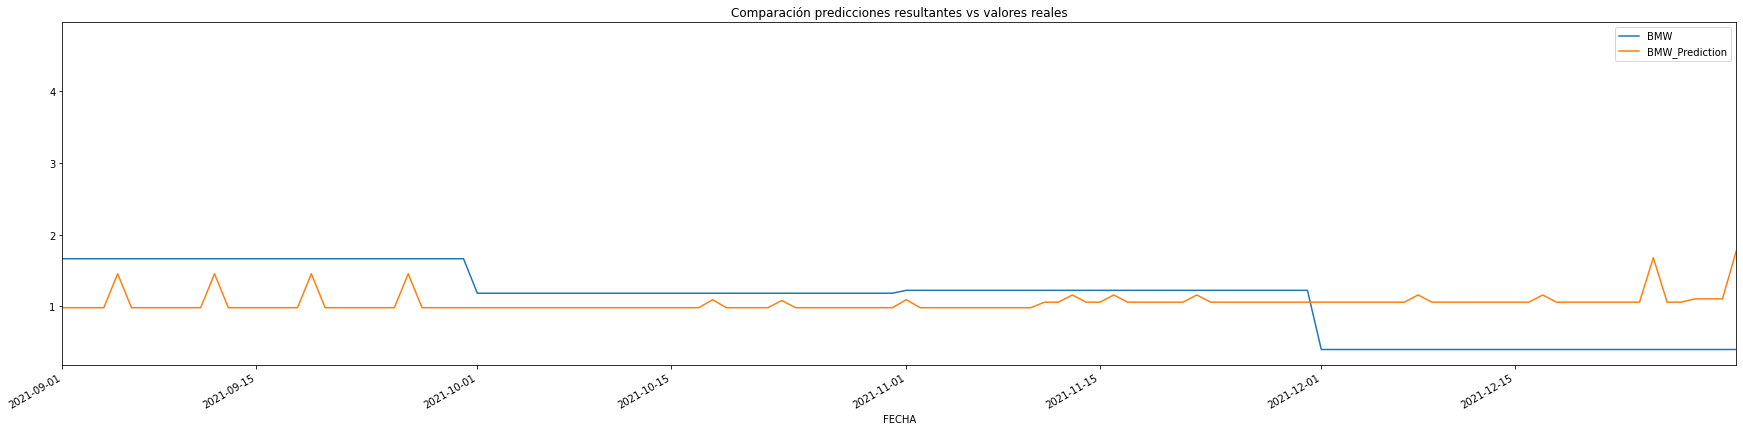

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(7)
f.set_figwidth(30)
df_all[['BMW','BMW_Prediction']].plot(ax=ax,
                                              style=['-','-'])
ax.set_xbound(lower='09-01-2021', upper='12-31-2021')
#ax.set_ylim(0, 80)
plot = plt.title('Comparación predicciones resultantes vs valores reales')

In [ ]:
mean_squared_error(y_true=df_test['BMW'],
                   y_pred=df_test['BMW_Prediction'])

0.25514581928394453

In [ ]:
mean_absolute_error(y_true=df_test['BMW'],
                   y_pred=df_test['BMW_Prediction'])

0.4785971373261991

In [ ]:
print ("R2 Score on the test subset: {:.3f}".format(r2_score(df_test['BMW'],df_test['BMW_Prediction'])))

R2 Score on the test subset: -0.272


In [ ]:
df_test['error'] = df_test['BMW'] - df_test['BMW_Prediction']
df_test['Date2'] = df_test.index.date
df_test['abs_error'] = df_test['error'].apply(np.abs)
error_by_day = df_test.groupby(['Date2']) \
    .mean()[['BMW','BMW_Prediction','error','abs_error']]

In [ ]:
error_by_day

,BMW,BMW_Prediction,error,abs_error
Date2,,,,
2021-07-01,3.051993,2.642529,0.409464,0.409464
2021-07-02,3.051993,2.642529,0.409464,0.409464
2021-07-03,3.051993,2.642529,0.409464,0.409464
2021-07-04,3.051993,2.642529,0.409464,0.409464
2021-07-05,3.051993,2.642529,0.409464,0.409464
...,...,...,...,...
2021-12-27,0.400507,1.412717,-1.012210,1.012210
2021-12-28,0.400507,1.515286,-1.114779,1.114779
2021-12-29,0.400507,1.515286,-1.114779,1.114779
